## Performance test on the CovidENV dataset

In this notebook we compare the clustering performance of k-means++, HDBSCAN, Quickshift++, and CLASSIX. The dataset is `CovidENV`, approximately 5.7 million three-dimensional data points corresponding to PaCMAP projections of RNA sequences of SARS-CoV-2 [1]. Here, `ENV` stands for the _Extended Natural Vector_ encoding that has been used for the numerical representation of each RNA. 

Quickshift++ runs out of memory for the full dataset, so we downsample to only 10%. The hyperparameters of HDBSCAN and CLASSIX are chosen as in the reference [1]. The hyperparameters for the other methods have been tuned by grid search. Should you find a set of parameters that improves a method significantly, please let us know and we will update this notebook.

The runtimes and plots of the computed clusterings are shown at the bottom of this notebook.

In [1]:
import hdbscan
from sklearn.cluster import KMeans
from quickshift.QuickshiftPP import *
from threadpoolctl import threadpool_limits
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from classix import CLASSIX, loadData
import classix
from time import time
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami
import collections

import pkg_resources
print("Kmeans++ version:", pkg_resources.get_distribution('scikit-learn').version)
print("HDBSCAN  version:", pkg_resources.get_distribution('hdbscan').version)
print("Quickshift++ ver: Aug 2018") # https://github.com/google/quickshift
print("CLASSIX  version:", classix.__version__)

Kmeans++ version: 1.2.1
HDBSCAN  version: 0.8.33
Quickshift++ ver: Aug 2018
CLASSIX  version: 1.0.5


In [2]:
CovidENV = loadData('CovidENV')
X, y = CovidENV
np.random.seed(42)
sampling = np.random.choice(np.arange(X.shape[0]), int(X.shape[0]*0.1), replace=False)
X, y = np.array(X), np.array(y)
X = MinMaxScaler().fit_transform(X)-0.5
X_sample, y_sample = X[sampling], y[sampling] # for Quickshift++
clusterNum = len(np.unique(y))

lari = list()
lami = list()
runtime = list()
min_cluster = min(collections.Counter(y).items(), key=lambda x: x[1])[1]

with threadpool_limits(limits=1, user_api='blas'):
    clx = classix.CLASSIX(radius=0.2, minPts=500, verbose=0)
    st = time()
    clx.fit(X)
    et = time()
    print("CLASSIX uses time:", et - st)
    print("ARI:", ari(clx.labels_, y))
    print("AMI:", ami(clx.labels_, y))
    lari.append(ari(clx.labels_, y))
    lami.append(ami(clx.labels_, y))
    runtime.append(et - st)

    _hdbscan = hdbscan.HDBSCAN(min_cluster_size=180000, min_samples=5, algorithm='best') 
    st = time()
    _hdbscan.fit(X)
    et = time()
    print("HDBSCAN uses time:", et - st)
    print("ARI:", ari(_hdbscan.labels_, y))
    print("AMI:", ami(_hdbscan.labels_, y))
    lari.append(ari(_hdbscan.labels_, y))
    lami.append(ami(_hdbscan.labels_, y))
    runtime.append(et - st)

    quicks = QuickshiftPP(k=3500, beta=0.9)
    st = time()
    quicks.fit(X_sample.copy(order='C'))
    et = time()
    print("Quickshift (10% of data!) uses time:", et - st)
    print("ARI:", ari(quicks.memberships, y_sample))
    print("AMI:", ami(quicks.memberships, y_sample))
    lari.append(ari(quicks.memberships, y_sample))
    lami.append(ami(quicks.memberships, y_sample))
    runtime.append(et - st)

    kmeans = KMeans(n_clusters=clusterNum, init='k-means++', n_init='auto', random_state=1)
    st = time()
    kmeans.fit(X)
    et = time()
    print("kmeans uses time:", et - st)
    print("ARI:", ari(kmeans.labels_, y))
    print("AMI:", ami(kmeans.labels_, y))
    lari.append(ari(kmeans.labels_, y))
    lami.append(ami(kmeans.labels_, y))
    runtime.append(et - st)

labels_ = [clx.labels_, _hdbscan.labels_, kmeans.labels_]# , depddp_class]
lari = np.asarray(lari)
lami = np.asarray(lami)
runtime = np.asarray(runtime)
np.save("result/exp1/CovidENV_ari.npy", lari)
np.save("result/exp1/CovidENV_ami.npy", lami)
np.save("result/exp1/CovidENV_runtime.npy", runtime)
np.save("result/exp1/CovidENV_labels.npy", labels_)
np.save("result/exp1/CovidENV_quicks_labels.npy", quicks.memberships)

CLASSIX uses time: 6.924267768859863
ARI: 0.33943509864262805
AMI: 0.5052318871530559
HDBSCAN uses time: 3778.4793150424957
ARI: 0.3339711058052982
AMI: 0.4814332687611449
Quickshift (10% of data!) uses time: 8401.480865955353
ARI: 0.2878131759502304
AMI: 0.4862100422250575
kmeans uses time: 16.477206230163574
ARI: 0.13479379433687988
AMI: 0.44163335669194903


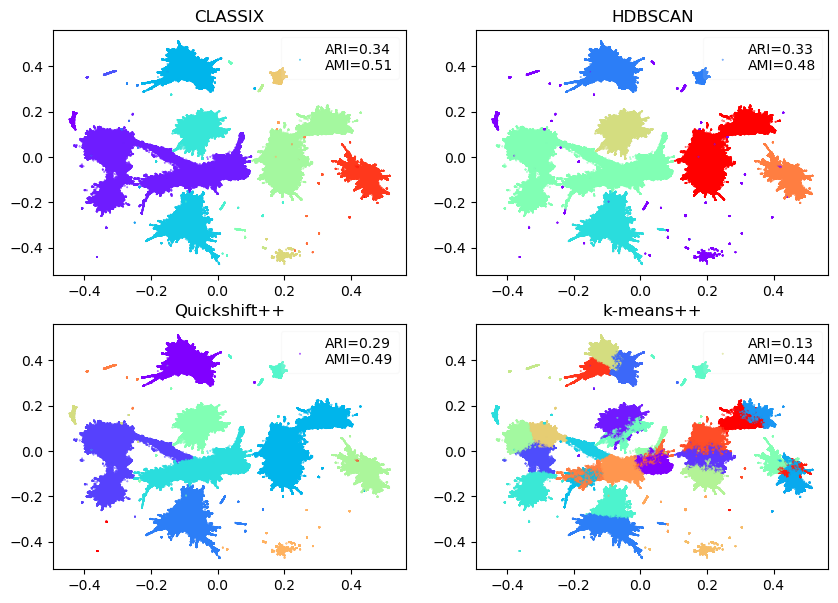

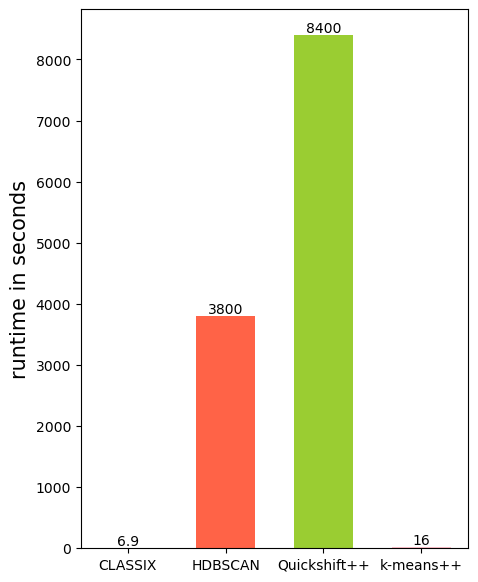

In [3]:
import math
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def sigificant_digit(number, digits=4):
    return round(number, digits - int(math.floor(math.log10(abs(number)))) - 1)
algorithms = ['CLASSIX', 'HDBSCAN', 'Quickshift++', 'k-means++']

lari = np.load("result/exp1/CovidENV_ari.npy")
lami = np.load("result/exp1/CovidENV_ami.npy")
labels = np.load("result/exp1/CovidENV_labels.npy")
runtime = np.load("result/exp1/CovidENV_runtime.npy")
labels_quicks = np.load("result/exp1/CovidENV_quicks_labels.npy")

runtime = [sigificant_digit(c, 2) for c in runtime]

pca = PCA(n_components=2)
CovidENV = loadData('CovidENV')
X, y = CovidENV
np.random.seed(42)
sampling = np.random.choice(np.arange(X.shape[0]), int(X.shape[0]*0.1), replace=False)
X, y = np.array(X), np.array(y)
X = MinMaxScaler().fit_transform(X)-0.5
X_sample, y_sample = X[sampling], y[sampling]
X = pca.fit_transform(X)
X_sample = pca.fit_transform(X_sample)

fig, axs = plt.subplots(2, 2, figsize=(10,7))

axs[0, 0].scatter(X[sampling, 0], X[sampling, 1], s=0.1, c=labels[0][sampling], cmap='rainbow', label='ARI={0:.2f}\nAMI={1:.2f}'.format(lari[0], lami[0]))
axs[0, 0].set_title(algorithms[0])
axs[0, 0].legend(loc='upper right', fancybox=True, framealpha=0.1)
axs[0, 1].scatter(X[sampling, 0], X[sampling, 1], s=0.1, c=labels[1][sampling], cmap='rainbow', label='ARI={0:.2f}\nAMI={1:.2f}'.format(lari[1], lami[1]))
axs[0, 1].set_title(algorithms[1])
axs[0, 1].legend(loc='upper right', fancybox=True, framealpha=0.1)
axs[1, 0].scatter(X_sample[:, 0], X_sample[:, 1], s=0.1, c=labels_quicks, cmap='rainbow', label='ARI={0:.2f}\nAMI={1:.2f}'.format(lari[2], lami[2]))
axs[1, 0].set_title(algorithms[2])
axs[1, 0].legend(loc='upper right', fancybox=True, framealpha=0.1)
axs[1, 1].scatter(X[sampling, 0], X[sampling, 1], s=0.1, c=labels[2][sampling], cmap='rainbow', label='ARI={0:.2f}\nAMI={1:.2f}'.format(lari[3], lami[3]))
axs[1, 1].set_title(algorithms[3])
axs[1, 1].legend(loc='upper right', fancybox=True, framealpha=0.1)
plt.savefig('result/exp1/scatter_CovidENV.png', bbox_inches='tight')
plt.show()

color = ['lightblue', 'tomato', 'yellowgreen', 'pink']
plt.figure(figsize=(5, 7))
plt.bar(algorithms, runtime, width=0.6, color=color)
#plt.yscale('log')
plt.ylabel('runtime in seconds', fontsize=15)
# add Bar labels
for c in plt.gca().containers:
    plt.gca().bar_label(c)
    
plt.savefig('result/exp1/bar_CovidENV.png', bbox_inches='tight')
plt.show()

## Reference

[1] R. Cahuantzi, K. Lythgoe, I. Hall, L. Pellis, and T. House. "Unsupervised identification of significant lineages of SARS-CoV-2 through scalable machine learning methods." bioRxiv 2022.09.14.507985, 2022. (https://doi.org/10.1101/2022.09.14.507985)